# Chapter 17: Representation Learning and Generative Learning Using Autoencoders and GANs

This notebook contains the code reproductions and theoretical explanations for Chapter 17 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*.

## Chapter Summary

This chapter explores two powerful unsupervised learning techniques: **Autoencoders** and **Generative Adversarial Networks (GANs)**. Both are capable of learning dense representations (codings) of data, but they work very differently.

**Autoencoders** learn to reconstruct their inputs. They are composed of an **encoder** that compresses the input into a low-dimensional **latent representation** (or coding) and a **decoder** that reconstructs the input from this coding. By constraining the autoencoder (e.g., limiting the size of the coding layer or adding noise to the inputs), we force it to learn important features.

Key autoencoder topics covered include:
* **Stacked Autoencoders:** Building deep autoencoders for dimensionality reduction or unsupervised pretraining.
* **Convolutional and Recurrent Autoencoders:** Applying the autoencoder concept to image and sequence data.
* **Denoising Autoencoders:** Training an autoencoder to recover a clean input from a corrupted (noisy) one.
* **Sparse Autoencoders:** Using regularization (like L1 or KL Divergence) to force the autoencoder to learn a sparse set of features.
* **Variational Autoencoders (VAEs):** A generative autoencoder that learns a probability distribution of the data. It can be used to generate new instances that look similar to the training data.

**GANs** are generative models composed of two competing networks: a **generator** that creates fake data and a **discriminator** that tries to distinguish the fake data from real data. This adversarial training pushes the generator to create increasingly realistic data.

Key GAN topics covered include:
* **Training Difficulties:** The challenges of training GANs, such as **mode collapse** (where the generator produces limited variety) and training instability.
* **Deep Convolutional GANs (DCGANs):** A set of architectural guidelines for building stable GANs using convolutional layers.
* **Progressive Growing of GANs:** A technique to generate very high-resolution images by starting with small images and progressively adding layers to both networks.
* **StyleGANs:** A state-of-the-art architecture that uses *style transfer* to control different levels of the generated image (e.g., fine-grained texture vs. high-level features) and produces incredibly realistic images.

## Setup

First, let's import the necessary libraries and set up the environment.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# Common setup for plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function to plot images (from chapter 10)
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Efficient Data Representations

### Theoretical Explanation

An **autoencoder** is an unsupervised neural network that learns to copy its inputs to its outputs. It has two parts:
1.  **Encoder:** Compresses the input data into a lower-dimensional latent representation (the *coding*).
2.  **Decoder:** Reconstructs the original data from the coding.

This task sounds trivial, but by placing constraints on the network, we force it to learn efficient patterns in the data. The most common constraint is to make the coding layer smaller than the input layer. This is called an **undercomplete autoencoder**. It's forced to learn the most important features (representation learning) to be able to reconstruct the input, effectively performing dimensionality reduction.

### Performing PCA with an Undercomplete Linear Autoencoder

If the autoencoder uses only linear activations (i.e., no activation function) and the loss function is the Mean Squared Error (MSE), it will end up performing Principal Component Analysis (PCA).

In [2]:
# Generate a 3D dataset (as in Chapter 8)
np.random.seed(42)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [3]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)

# Use the encoder to project the data to 2D
codings = encoder.predict(X_train)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5257  
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4568
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3284
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2691
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2597
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2344
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2215
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1843
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1782 
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1645
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1402
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1283
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1234
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1098
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0972
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━

## Stacked Autoencoders

**Theoretical Explanation:**

Autoencoders can have multiple hidden layers, just like a regular MLP. When they do, they are called **stacked autoencoders** (or deep autoencoders). Adding more layers helps the network learn more complex codings. The architecture is typically *symmetrical* around the central coding layer (e.g., 784 -> 100 -> 30 -> 100 -> 784).

### Implementing a Stacked Autoencoder Using Keras

We'll build a stacked autoencoder for Fashion MNIST. We use binary cross-entropy as the loss because it treats the reconstruction task as a multilabel binary classification problem (is this pixel black or white?), which often helps the model converge faster.

In [5]:
# Load Fashion MNIST data (as in Chapter 10)
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"), # This is the coding layer
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.3807 - val_loss: 0.3125
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3085 - val_loss: 0.3039
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3010 - val_loss: 0.2984
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2965 - val_loss: 0.2983
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2938 - val_loss: 0.2957
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2912 - val_loss: 0.2926
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2903 - val_loss: 0.2902
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2895 - val_loss: 0.2908
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2877 - val_loss: 0.2884
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2866 - val_loss: 0.2876


### Visualizing the Reconstructions

Let's check how well the autoencoder reconstructs the images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


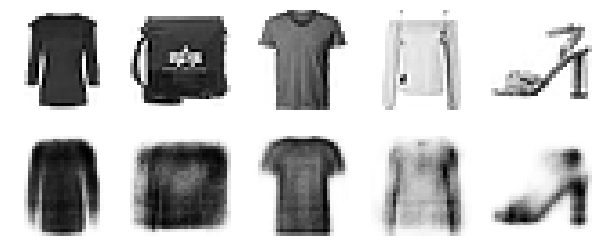

In [8]:
def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

### Visualizing the Fashion MNIST Dataset

Autoencoders are a powerful tool for dimensionality reduction. We can use the encoder to reduce the 784-dimensional input to 30-dimensional codings, then use another technique like t-SNE to reduce it further to 2D for visualization.

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


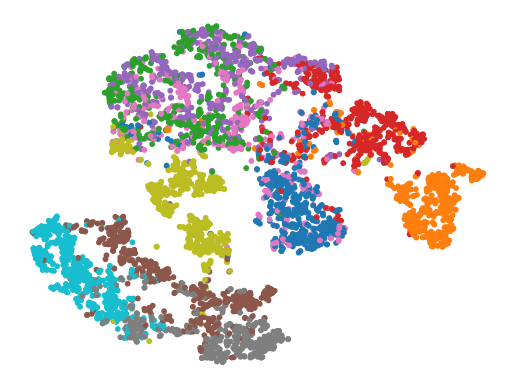

In [9]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

### Unsupervised Pretraining Using Stacked Autoencoders

**Theoretical Explanation:**

A key application of autoencoders is unsupervised pretraining. If you have a complex task (like classification) but very little *labeled* data, you can first train a stacked autoencoder on all your data (labeled + unlabeled).

This autoencoder will learn to detect useful features and patterns in the data. You can then take the encoder part of the autoencoder, add a new output layer (e.g., a Dense classification layer) on top, and fine-tune this new model on your small *labeled* dataset. This reuse of layers is a form of transfer learning.

### Tying Weights

**Theoretical Explanation:**

When an autoencoder is symmetrical, a common technique is to **tie the weights** of the decoder layers to the weights of the encoder layers. Specifically, the decoder's weight matrix is set to be the *transpose* of the corresponding encoder's weight matrix (**W**_decoder_ = **W**_encoder_ᵀ).

This halves the number of parameters in the model, which speeds up training and reduces the risk of overfitting.

In [10]:
# We need a custom layer to implement tied weights
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        # Use the transposed kernel of the encoder layer
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# We need a custom layer to implement tied weights
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        # The bias of the transposed layer should have a size equal to the input features of the original dense layer.
        # The kernel of self.dense (self.dense.weights[0]) has shape (input_features, units).
        # So, the first dimension of the kernel (index 0) gives the input_features.
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.weights[0].shape[0]])
        super().build(batch_input_shape)
    def call(self, inputs):
        # Use the transposed kernel of the encoder layer
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5))
history_tied = tied_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3710 - val_loss: 0.3028
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2993 - val_loss: 0.2944
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2918 - val_loss: 0.2898
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2886 - val_loss: 0.2878
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2864 - val_loss: 0.2861
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2846 - val_loss: 0.2853
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2836 - val_loss: 0.2877
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2826 - val_loss: 0.2850
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2817 - val_loss: 0.2827
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2808 - val_loss: 0.2824


## Convolutional Autoencoders

For images, autoencoders made of dense layers won't work well. We should use **convolutional autoencoders**.

* The **encoder** is a standard CNN (Conv2D and MaxPool2D layers) that downsamples the image into a latent representation.
* The **decoder** must do the reverse: it must *upsample* the image. This is typically done using `Conv2DTranspose` layers (also called deconvolutional layers).

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load Fashion MNIST data (as in Chapter 10)
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2) # Output shape: [3, 3, 64]
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                                  activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                                  activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                  activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))
history_conv = conv_ae.fit(X_train, X_train, epochs=5,
                         validation_data=(X_valid, X_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step - loss: 0.3346 - val_loss: 0.2790
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - loss: 0.2775 - val_loss: 0.2730
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 57s 33ms/step - loss: 0.2716 - val_loss: 0.2706
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - loss: 0.2687 - val_loss: 0.2677
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - loss: 0.2673 - val_loss: 0.2704


## Denoising Autoencoders

**Theoretical Explanation:**

Another way to force the autoencoder to learn useful features is to add noise to its inputs (e.g., using Gaussian noise or dropout) and train it to recover the *original, noise-free* inputs.

The autoencoder is forced to learn patterns in the data so it can distinguish the underlying signal from the noise. This makes it a good feature extractor and can also be used to clean up noisy images.

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load Fashion MNIST data (as in Chapter 10)
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5), # Add noise to the inputs
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))

# Note: We feed the noisy inputs (X_train_noisy) but the target is the clean inputs (X_train).
# For this example, we'll use Dropout, so the inputs are X_train and targets are X_train.
history_denoising = dropout_ae.fit(X_train, X_train, epochs=10,
                                 validation_data=(X_valid, X_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.4040 - val_loss: 0.3215
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3213 - val_loss: 0.3132
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3151 - val_loss: 0.3091
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3111 - val_loss: 0.3061
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3088 - val_loss: 0.3042
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3070 - val_loss: 0.3028
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3050 - val_loss: 0.3014
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3046 - val_loss: 0.3004
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3037 - val_loss: 0.2993
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3030 - val_loss: 0.2988


## Sparse Autoencoders

**Theoretical Explanation:**

A **sparse autoencoder** is an autoencoder (typically overcomplete) that is constrained to produce a *sparse* latent representation. This means most of the neurons in the coding layer are inactive (output zero).

This forces the model to represent each input as a combination of a small number of "active" features, pushing each coding neuron to learn a useful and specific feature.

Two ways to achieve sparsity:
1.  **L1 Regularization:** Add L1 regularization to the *activations* of the coding layer. This pushes the model to output zeros.
2.  **KL Divergence:** A more complex method. We measure the average activation of each coding neuron over a batch and penalize it if it deviates from a target sparsity (e.g., 0.1).

In [14]:
# 1. Sparse Autoencoder with L1 Regularization
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"), # Overcomplete coding layer
    # Add L1 regularization to the layer's *activity*
    keras.layers.ActivityRegularization(l1=1e-3)
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))

In [15]:
# 2. Sparse Autoencoder with KL Divergence
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
    def get_config(self):
        return {"weight": self.weight, "target": self.target}

In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
    def get_config(self):
        return {"weight": self.weight, "target": self.target}

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0))

## Variational Autoencoders

**Theoretical Explanation:**

**Variational Autoencoders (VAEs)** are different from other autoencoders.
1.  They are **probabilistic**: their outputs are partly determined by chance, even after training.
2.  They are **generative**: they can generate new instances that look like they were sampled from the training set.

How they work:
* Instead of mapping an input to a single point (coding), the **encoder** maps the input to a probability distribution. Specifically, it outputs a **mean (μ)** and a **standard deviation (σ)**.
* A **coding** is then randomly *sampled* from a Gaussian distribution with this mean μ and standard deviation σ.
* The **decoder** then takes this sampled coding and reconstructs the input.

**The VAE Loss Function:**
The model is trained with a composite loss function:
1.  **Reconstruction Loss:** This is the standard loss (e.g., binary cross-entropy) that pushes the model to reconstruct its input. It's the `decoder_loss`.
2.  **Latent Loss (KL Divergence):** This loss pushes the model to make the codings look as if they were sampled from a simple standard Gaussian distribution (mean=0, std=1). This regularization ensures that the *latent space* (the space of all possible codings) is well-organized and dense, which allows us to generate new instances.

In [20]:
import keras.ops as ops

# We need a custom sampling layer
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        # Use keras.ops for these operations
        return ops.random_normal(ops.shape(log_var)) * ops.exp(log_var / 2) + mean

In [18]:
# Build the VAE (using the Functional API)
codings_size = 10

# --- Encoder ---
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)    # μ
codings_log_var = keras.layers.Dense(codings_size)(z) # γ = log(σ²)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# --- Decoder ---
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# --- VAE Model ---
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [25]:
import keras.ops as ops
import tensorflow as tf # Required for tf.GradientTape

# VAE Model (subclassing keras.Model to handle custom loss)
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Metrics to track individual loss components
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # This call method is used for inference/prediction.
        # For training, train_step is primarily used.
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructions = self.decoder(z)
        return reconstructions

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # `data` is a tuple (x, y) when called with fit(x, y)
        # For autoencoders, x == y. We only need the input 'x'.
        x = data[0] if isinstance(data, tuple) else data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstructions = self.decoder(z)

            # Reconstruction loss: binary cross-entropy, summed over pixels, then averaged over batch
            # keras.losses.binary_crossentropy returns a per-element loss if reduction=NONE (default for direct call)
            # Sum over last two axes (image dimensions) then mean over batch
            reconstruction_loss = keras.losses.binary_crossentropy(x, reconstructions, axis=(1, 2)) # per image loss
            reconstruction_loss = ops.mean(reconstruction_loss) # mean over batch

            # KL divergence loss: sum over latent dimensions, then averaged over batch, scaled by 784
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.sum(kl_loss, axis=1) # Sum over latent dimensions per sample
            kl_loss = ops.mean(kl_loss) / (28 * 28) # Mean over batch, then scale by number of pixels (784)

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0] if isinstance(data, tuple) else data
        z_mean, z_log_var, z = self.encoder(x)
        reconstructions = self.decoder(z)

        reconstruction_loss = keras.losses.binary_crossentropy(x, reconstructions, axis=(1, 2))
        reconstruction_loss = ops.mean(reconstruction_loss)

        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.sum(kl_loss, axis=1)
        kl_loss = ops.mean(kl_loss) / (28 * 28)

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Instantiate the custom VAE model using the previously defined encoder and decoder
variational_ae = VAE(variational_encoder, variational_decoder)

# Compile the custom VAE model
# The loss is handled within train_step, so we don't pass a loss function here.
variational_ae.compile(optimizer="rmsprop")

In [26]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 0.0194 - loss: 0.4733 - reconstruction_loss: 0.4539 - val_kl_loss: 0.0210 - val_loss: 0.3478 - val_reconstruction_loss: 0.3267
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - kl_loss: 0.0204 - loss: 0.3599 - reconstruction_loss: 0.3395 - val_kl_loss: 0.0190 - val_loss: 0.3211 - val_reconstruction_loss: 0.3021
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - kl_loss: 0.0191 - loss: 0.3461 - reconstruction_loss: 0.3270 - val_kl_loss: 0.0183 - val_loss: 0.3137 - val_reconstruction_loss: 0.2955
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - kl_loss: 0.0183 - loss: 0.3391 - reconstruction_loss: 0.3207 - val_kl_loss: 0.0179 - val_loss: 0.3111 - val_reconstruction_loss: 0.2932
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - kl_loss: 0.0178 - loss: 0.3339 - reconstruction_loss: 0.3162 - val_kl_loss: 0.0173 - val_loss: 0.3077 - val_reconstruction_loss: 0.2904
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 16

### Generating Fashion MNIST Images

Because the VAE learned a probability distribution in its latent space, we can sample a random point from that space (a simple Gaussian distribution) and pass it to the decoder to generate a brand new image.

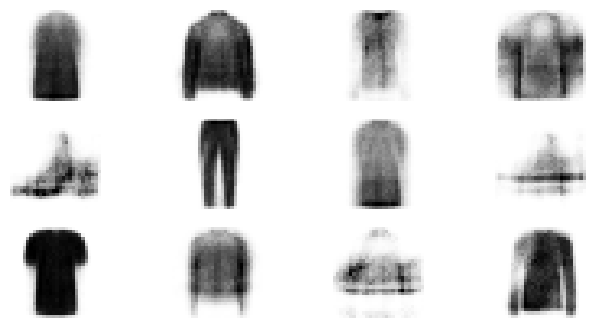

In [27]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

# Plot the generated images
plt.figure(figsize=(8, 4))
for index, image in enumerate(images):
    plt.subplot(3, 4, index + 1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
plt.show()

## Generative Adversarial Networks

**Theoretical Explanation:**

**GANs** are a completely different approach to generative modeling. They consist of two networks in competition:

1.  **The Generator:** Its job is to create fake data (e.g., images). It takes random noise (latent representations) as input and tries to output data that looks like it came from the training set.
2.  **The Discriminator:** Its job is to be a classifier. It takes an image as input (either a *real* one from the training set or a *fake* one from the generator) and tries to predict if it's real or fake.

**The Training Process:**
This is a *zero-sum game* between the two networks.
* **Phase 1: Train the Discriminator.** We create a batch of fake images from the generator and a batch of real images. We label the fake images '0' and the real images '1'. We then train the discriminator on this batch for one step (with the generator's weights frozen).
* **Phase 2: Train the Generator.** We create a new batch of fake images. We label them all '1' (as in "real"). We then train the *full GAN model* (with the discriminator's weights frozen). The gradients will flow back from the discriminator to the generator, teaching the generator how to produce images that the discriminator will classify as '1'.

Over time, the generator gets better at making fakes, and the discriminator gets better at spotting them, until (ideally) the generator produces perfectly realistic images.

In [28]:
# Build the GAN components for Fashion MNIST
codings_size = 30

# The Generator (a decoder)
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# The Discriminator (a classifier)
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# The full GAN model
gan = keras.models.Sequential([generator, discriminator])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Compile the models
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False # This is key for phase 2
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [30]:
# Prepare the dataset
batch_size = 32
# We reshape and rescale the data to -1 to 1 for the sigmoid output (tanh is better)
# For this simple GAN, sigmoid (0 to 1) is fine. We will not rescale.
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [31]:
# The custom training loop
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # --- Phase 1: Train the Discriminator ---
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # --- Phase 2: Train the Generator ---
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size) # We want the discriminator to be Fooled

            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        # You would typically add code to generate and save images here


In [32]:
# Train for 1 epoch to demonstrate (real training takes hours)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/1


### The Difficulties of Training GANs

Training GANs is notoriously hard. The two networks are in a zero-sum game that needs to reach a **Nash equilibrium** (where the generator produces perfectly realistic images and the discriminator is forced to guess 50/50).

However, this equilibrium is very unstable. The main problems are:

* **Mode Collapse:** The generator gets good at producing one type of image (e.g., a good-looking shoe) and only produces that. It forgets how to make anything else. The discriminator then learns to spot this one type of fake, and the generator moves on to another single class, and so on.
* **Instability:** The parameters may oscillate or diverge as the two networks constantly try to outsmart each other.

### Deep Convolutional GANs (DCGAN)

The DCGAN architecture proposed a set of guidelines to make GANs more stable:

* Replace pooling layers with **strided convolutions** (in the discriminator) and **transposed convolutions** (in the generator).
* Use **Batch Normalization** in both networks (except the generator's output and discriminator's input).
* Remove fully connected hidden layers for deeper architectures.
* Use `ReLU` in the generator (except for the output, which uses `tanh`).
* Use `LeakyReLU` in the discriminator.

The code below implements a DCGAN, but uses `SELU` in the generator and `Dropout` in the discriminator (as the book notes, BN was unstable in this case).

In [33]:
# Rescale the training set to -1 to 1 (for the tanh output)
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                  activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                  activation="tanh")
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Train for 1 epoch to demonstrate
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/1


### Progressive Growing of GANs & StyleGAN

**Theoretical Explanation:**

More recent architectures have produced stunningly realistic images.

* **Progressive Growing of GANs (ProGAN):** Instead of generating high-res images from the start, the model is trained to generate very small images (e.g., 4x4), and then new layers are progressively added to both the generator and discriminator to double the resolution (8x8, 16x16, ... up to 1024x1024). This is much more stable.

* **StyleGAN:** The current state-of-the-art. Its generator uses two networks:
    1.  A **Mapping Network** (an MLP) that converts the input coding (z) into a *style vector* (w).
    2.  A **Synthesis Network** that generates the image. The style vector (w) is used to control the "style" of the image at each convolutional layer (via a technique called *Adaptive Instance Normalization*). This allows for incredible control over the generated image. It also injects noise at each level to generate realistic stochastic details (like freckles or hair placement).